# This Algorithm Outputs the Yearly Inland Water Extent

In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import json

In [2]:
geemap.ee_initialize()

In [3]:
m = geemap.Map(center=[20,0],zoom=2)

In [4]:
def geometry_geoJson(file_path):
  with open(file_path) as f:
      json_data = json.load(f)
  moi =  geemap.geojson_to_ee(json_data)
  return moi


def inland_water_extent(startDate, endDate, roi, filename):

    start = startDate
    end = endDate
    waterMonthly = ee.ImageCollection('JRC/GSW1_4/YearlyHistory').filterDate(start, end)


    def func_mask(i):
        return i.eq(3).updateMask(i.gt(0)).copyProperties(i, ['system:time_start'])

    waterMonthlyMask = waterMonthly.map(func_mask)
    waterOccurrence = waterMonthlyMask.mean().clip(roi)

    # Add visualization to map (assuming you have a geemap.Map instance `m`)
    m.addLayer(waterOccurrence, {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'Water Occurrence')
    m.centerObject(roi, 9)

    extend = []
    def cal_area(fea):
        area = ee.Image.pixelArea().updateMask(fea).reduceRegion(
             reducer=ee.Reducer.sum(), geometry=roi, scale=30,bestEffort=True).get('area')
        kmarea = ee.Number(area).divide(1e6)
        # extend.append({'m2': ee.Number(area), 'km2': ee.Number(kmarea), 'time': fea.get('system:time_start')})
        return fea.set({'m2': area, 'km2': kmarea})

    data = waterMonthlyMask.map(cal_area)

    data_list = data.getInfo()['features']
    area_list = [{'m2': f['properties']['m2'], 'km2': f['properties']['km2'], 'time': f['properties']['system:time_start']} for f in data_list]

    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(area_list,index=[x for x in range(1,len(area_list)+1)])

    # Convert the 'time' column to datetime
    df['time'] = pd.to_datetime(df['time'], unit='ms')

    # Sort the DataFrame by time
    df = df.sort_values(by='time')

    # Display the Table
    print(df)
    print('\n')

    #save the Table
    df.to_csv(f"{filename}.csv")

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Plot km2
    ax[0].plot(df['time'], df['km2'], marker='o')
    ax[0].set_ylabel('Area (km²)')
    ax[0].set_title('Surface Water Extent Time Series (km²)')
    ax[0].grid(True)

    # Plot m2
    ax[1].plot(df['time'], df['m2'], marker='o', color='red')
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Area (m²)')
    ax[1].set_title('Surface Water Extent Time Series (m²)')
    ax[1].grid(True)

    plt.tight_layout()

    # Save Plot
    plt.savefig(f"{filename}.jpg")
    plt.show()

             m2           km2       time
1  2.778232e+10  27782.319284 2018-01-01
2  2.778204e+10  27782.038084 2019-01-01
3  2.778342e+10  27783.421875 2020-01-01




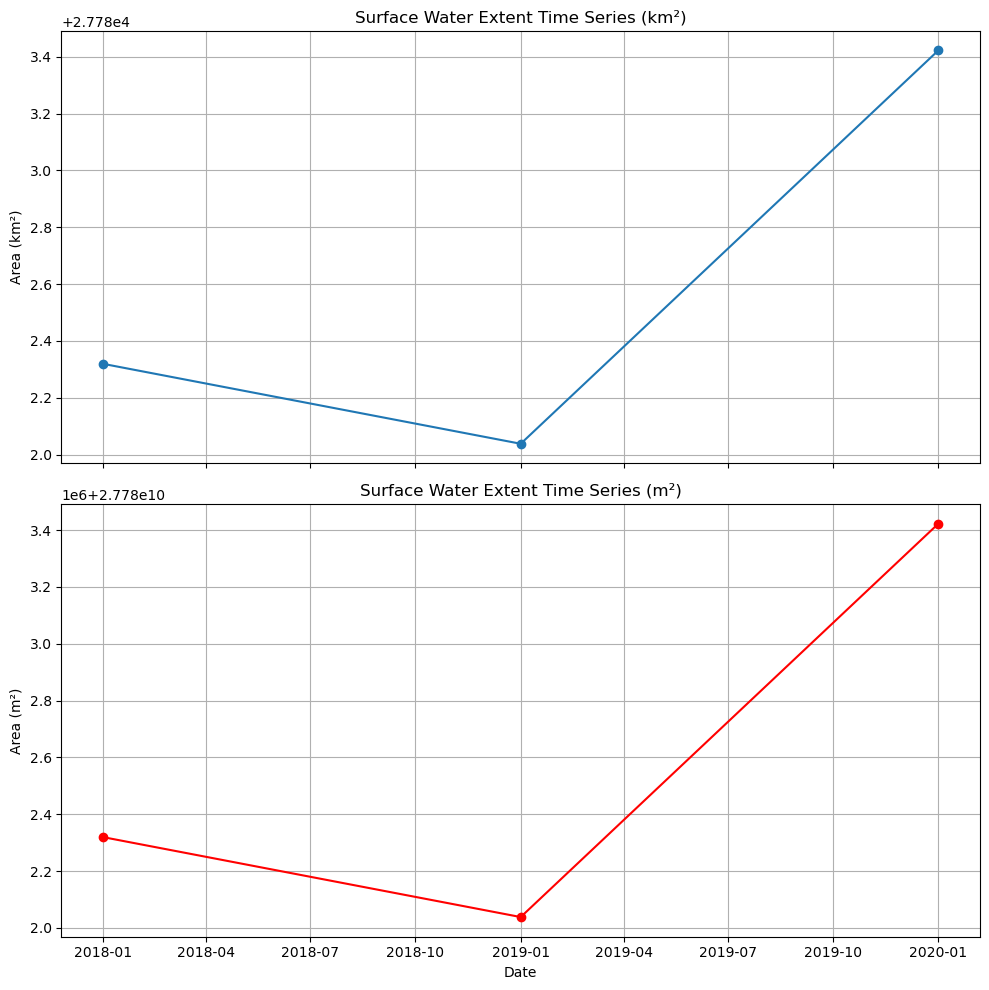

In [5]:
moi = geometry_geoJson("LakeMalawi.geojson")
inland_water_extent('2018-01-01', '2020-12-31', moi, 'Lake_Malawi')

In [6]:
m

Map(center=[-11.973534422573183, 34.512574691945694], controls=(WidgetControl(options=['position', 'transparen…